<a href="https://colab.research.google.com/github/Paul-mwaura/ML-Hackathons/blob/main/AI4D_iCompass_Social_Media_Sentiment_Analysis_for_Tunisian_Arabizi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## AI4D iCompass Social Media Sentiment Analysis for Tunisian Arabizi

### Business Understanding

On social media, Arabic speakers tend to express themselves in their own local dialect. To do so, Tunisians use ‘Tunisian Arabizi’, where the Latin alphabet is supplemented with numbers. However, annotated datasets for Arabizi are limited; in fact, this challenge uses the only known Tunisian Arabizi dataset in existence.

Sentiment analysis relies on multiple word senses and cultural knowledge, and can be influenced by age, gender and socio-economic status.For this task, we have collected and annotated sentences from different social media platforms. The objective of this challenge is to, given a sentence, classify whether the sentence is of positive, negative, or neutral sentiment. For messages conveying both a positive and negative sentiment, whichever is the stronger sentiment should be chosen. Predict if the text would be considered positive, negative, or neutral (for an average user). This is a binary task.

### Loading Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("white")

from sklearn.model_selection import train_test_split # function for splitting data to train and test sets

import re, string
import nltk
from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier
#from wordcloud import WordCloud,STOPWORDS
from subprocess import check_output

### Loading the Dataset

In [ ]:
df = pd.read_csv("Train.csv")
df.head()

,ID,text,label
0,13P0QT0,3sbaaaaaaaaaaaaaaaaaaaa lek ou le seim riahi o...,-1
1,SKCLXCJ,cha3eb fey9elkoum menghir ta7ayoul ou kressi,-1
2,V1TVXIJ,bereau degage nathef ya slim walahi ya7chiw fi...,-1
3,U0TTYY8,ak slouma,1
4,68DX797,entom titmanou lina a7na 3iid moubarik a7na ch...,-1


In [ ]:
df.shape

(70000, 3)

In [ ]:
len(df['ID'].unique())

70000

### Data Cleaning

In [ ]:
df.isna().sum()

ID       0
text     0
label    0
dtype: int64

In [ ]:
df.duplicated().sum()

0

### Exploratory Data Analysis

In [ ]:
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter

from tqdm import tqdm
import os
import nltk
import spacy
import random
from spacy.util import compounding
from spacy.util import minibatch

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Splitting the dataset into train and test set
train, test = train_test_split(df,test_size = 0.3, random_state = 41)
# Removing neutral sentiments
train = train[train.label != "0"]

As a next step I separated the Positive and Negative tweets of the training set in order to easily visualize their contained words. After that I cleaned the text from hashtags, mentions and links. Now they were ready for a WordCloud visualization which shows only the most emphatic words of the Positive and Negative tweets.

In [ ]:
train.describe()

,label
count,49000.000000
mean,0.124082
std,0.974329
min,-1.000000
25%,-1.000000
50%,1.000000
75%,1.000000
max,1.000000


In [ ]:
temp = train.groupby('label').count()['text'].reset_index().sort_values(by='text',ascending=False)
temp.style.background_gradient(cmap='Purples')

,label,text
2,1,26675
0,-1,20595
1,0,1730


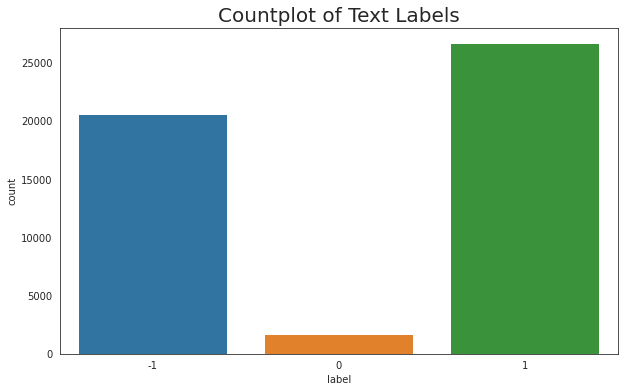

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(x='label',data=train)
plt.title("Countplot of Text Labels", fontsize=20)
plt.show()

Let's draw a Funnel-Chart for better visualization

In [ ]:
fig = go.Figure(go.Funnelarea(
    text =temp.label,
    values = temp.text,
    title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}
    ))
fig.show()

#### Generating Meta-Features
In the previous versions of this notebook,I used Number of words in selected text and main text ,Length of words in text and selected as main meta features,but in the context of this competition where we have to predict selected_text which is a subset of text, more useful features to generate would be :-

Difference In Number Of words of Selected_text and Text
Jaccard Similarity Scores between text and Selected_text
Thus it will not be useful for us to generate features we used before as they are of no importance here

For what who don't know what Jaccard Similarity is : https://www.geeksforgeeks.org/find-the-jaccard-index-and-jaccard-distance-between-the-two-given-sets/

In [ ]:
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [ ]:
results_jaccard=[]

for ind,row in df.iterrows():
    sentence1 = row.text
    sentence2 = row.text

    jaccard_score = jaccard(sentence1,sentence2)
    results_jaccard.append([sentence1,sentence2,jaccard_score])

In [ ]:
df['num_words'] = df['text'].str.split().str.len()
df.head()

,ID,text,label,num_words
0,13P0QT0,3sbaaaaaaaaaaaaaaaaaaaa lek ou le seim riahi o...,-1,10
1,SKCLXCJ,cha3eb fey9elkoum menghir ta7ayoul ou kressi,-1,6
2,V1TVXIJ,bereau degage nathef ya slim walahi ya7chiw fi...,-1,64
3,U0TTYY8,ak slouma,1,2
4,68DX797,entom titmanou lina a7na 3iid moubarik a7na ch...,-1,17


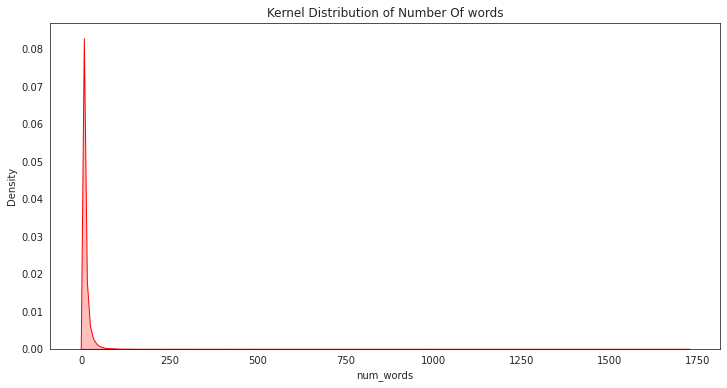

In [ ]:
plt.figure(figsize=(12,6))
p1=sns.kdeplot(df['num_words'], shade=True, color="r").set_title('Kernel Distribution of Number Of words')


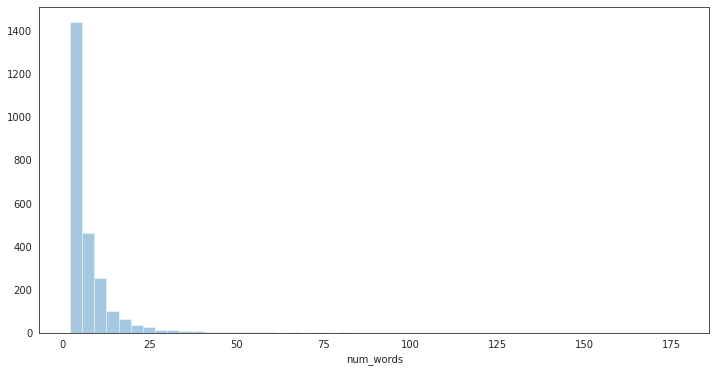

In [ ]:
plt.figure(figsize=(12,6))
sns.distplot(df[df['label']== 0]['num_words'],kde=False)

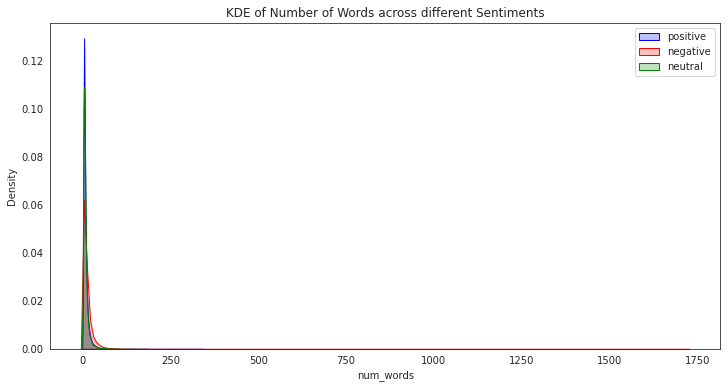

In [ ]:
plt.figure(figsize=(12,6))
p1=sns.kdeplot(df[df['label']== 1]['num_words'], shade=True, color="b").set_title('KDE of Number of Words across different Sentiments')
p2=sns.kdeplot(df[df['label']== -1]['num_words'], shade=True, color="r")
p3=sns.kdeplot(df[df['label']== 0]['num_words'], shade=True, color="g")
plt.legend(labels=['positive','negative', 'neutral'])

In [ ]:
k = df[df['num_words']<=2]

In [ ]:
k[k['label'] == 1]

,ID,text,label,num_words
3,U0TTYY8,ak slouma,1,2
22,CCUHTN5,b1 dit,1,2
46,WD76HAO,machalah alik,1,2
67,E39K9D6,wahrani slouma,1,2
109,CK8ZO6N,vrooom vrooom,1,2
...,...,...,...,...
69971,1K2SBE2,hhh m3alm,1,2
69974,F0ZH58N,tereb7ou i,1,2
69975,WWV2OGG,bravooooooooooooooooooooooo marou9iiii,1,2
69976,0VQ5W3U,rabi yechfiiih,1,2


In [ ]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('<.*?>+', '', text)
    text = re.sub("s+"," ", text)
    text = re.sub("[^-9A-Za-z ]", "" , text)
    return text

In [ ]:
df['text'] = df['text'].apply(lambda x:clean_text(x))
train['text'] = train['text'].apply(lambda x:clean_text(x))
test['text'] = test['text'].apply(lambda x:clean_text(x))

In [ ]:
train.head()

,ID,text,label
22837,H7SGU9H,men ayna laka hedha ya zawali,-1
14335,FEQGB64,ya 9aba nik omk w om zaimek ya taana tfiiiih a...,-1
47042,DGSCN0J,kolau aime oi alifrigui bikhayr,1
25967,AALBC1N,i bien,1
38858,RE313WA,malla ala fik wallah tlaet thez w tonfodh taya...,-1


In [ ]:
train['temp_list'] = train['text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in train['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,w,13826
1,ya,6731
2,fi,6329
3,el,5874
4,a,5358
5,i,5243
6,lim,5103
7,rabi,4530
8,ma,4078
9,la,4057


In [ ]:
fig = px.bar(temp, x="count", y="Common_words", title='Commmon Words in Selected Text', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

In [ ]:
top = Counter([item for sublist in train['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp = temp.iloc[1:,:]
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Purples')

,Common_words,count
1,ya,6731
2,fi,6329
3,el,5874
4,a,5358
5,i,5243
6,lim,5103
7,rabi,4530
8,ma,4078
9,la,4057
10,e,3181


In [ ]:
fig = px.bar(temp, x="count", y="Common_words", title='Commmon Words in Text', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

##### Most common words Sentiments Wise
Let's look at the most common words in different sentiments

In [ ]:
train.head(2)

,ID,text,label,temp_list
22837,H7SGU9H,men ayna laka hedha ya zawali,-1,"[men, ayna, laka, hedha, ya, zawali]"
14335,FEQGB64,ya 9aba nik omk w om zaimek ya taana tfiiiih a...,-1,"[ya, 9aba, nik, omk, w, om, zaimek, ya, taana,..."


In [ ]:
train.shape

(49000, 4)

#### Obsevations

### Modelling
 

#### SVM

In [ ]:
# Training Support Vector Machines - SVM and calculating its performance

from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

text_clf_svm = Pipeline([('vect', TfidfVectorizer()),
                         ('clf-svm', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, max_iter=5, random_state=42))])

text_clf_svm = text_clf_svm.fit(train.text, train.label)
predicted_svm = text_clf_svm.predict(test.text)
np.mean(predicted_svm == test.label)

0.701952380952381

#### KNeighbors Classifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier 

In [ ]:
knn_clf = Pipeline([('vect', TfidfVectorizer()), ('clf', KNeighborsClassifier(
    n_neighbors=5, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski'
))])

knn_clf = knn_clf.fit(train.text, train.label)

In [ ]:
predicted_knn = knn_clf.predict(test.text)
np.mean(predicted_knn == test.label)

0.5939047619047619

### Loading Test Data

In [ ]:
test_data = pd.read_csv("Test.csv")
test_data.head(3)

,ID,text
0,2DDHQW9,barcha aaindou fiha hak w barcha teflim kadhalik
1,5HY6UEY,ye gernabou ye 9a7ba
2,ATNVUJX,saber w barra rabbi m3ak 5ouya


#### Clean Test Data

In [ ]:
test_data.isna().sum()

ID      0
text    0
dtype: int64

In [ ]:
test_data.duplicated().sum()

0

#### Preprocessing Test Data

In [ ]:
test_data['text'] = test_data['text'].apply(lambda x:clean_text(x))
test_data.head(2)

,ID,text
0,2DDHQW9,barcha aaindou fiha hak w barcha teflim kadhalik
1,5HY6UEY,ye gernabou ye 9aba


In [ ]:
train_data = train[['text', 'label']]
train_data.head(3)

,text,label
22837,men ayna laka hedha ya zawali,-1
14335,ya 9aba nik omk w om zaimek ya taana tfiiiih a...,-1
47042,kolau aime oi alifrigui bikhayr,1


In [ ]:
X = train_data['text']
y = train_data['label']

In [ ]:
# Splitting the dataset into train and test set
from sklearn.model_selection import train_test_split
seed = 12
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.3, random_state=12)
X.shape, y.shape

((49000,), (49000,))

### Multinormial NB

In [ ]:
# Extracting features from text files
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(train['text'])
X_train_counts.shape

# TF-IDF
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

# Machine Learning
# Training Naive Bayes (NB) classifier on training data.
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_tfidf, train.label)


# Building a pipeline: We can write less code and do all of the above, by building a pipeline as follows:
# The names ‘vect’ , ‘tfidf’ and ‘clf’ are arbitrary but will be used later.
# We will be using the 'text_clf' going forward.
from sklearn.pipeline import Pipeline

text_clf = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', MultinomialNB())])

text_clf = text_clf.fit(train.text, train.label)

# Performance of NB Classifier
import numpy as np
predicted = text_clf.predict(test.text)
np.mean(predicted == test.label)*100

77.8952380952381

In [ ]:
from sklearn.linear_model import LogisticRegression

# lr = LogisticRegression().fit(X_train_tfidf, train.label)

# Building a pipeline: We can write less code and do all of the above, by building a pipeline as follows:
# The names ‘vect’ , ‘tfidf’ and ‘clf’ are arbitrary but will be used later.
# We will be using the 'text_clf' going forward.
from sklearn.pipeline import Pipeline

lr_clf = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', LogisticRegression())])

lr_clf = lr_clf.fit(train.text, train.label)

# Performance of NB Classifier
import numpy as np
predicted = lr_clf.predict(test.text)
np.mean(predicted == test.label)*100

78.58095238095238

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_depth=2, random_state=0)

rf_clf = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', RandomForestClassifier())])

rf_clf = rf_clf.fit(train.text, train.label)

# Performance of NB Classifier
import numpy as np
predicted = rf_clf.predict(test.text)
np.mean(predicted == test.label)*100

75.31904761904762

### Submission

In [ ]:
sub = pd.read_csv("SampleSubmission.csv")
submission = pd.DataFrame()
submission['ID'] = test_data['ID']
submission.head()

,ID
0,2DDHQW9
1,5HY6UEY
2,ATNVUJX
3,Q9XYVOQ
4,TOAHLRH


In [ ]:
submission.shape

(30000, 1)

In [ ]:
pred = lr_clf.predict(test_data['text'])
pred

array([ 1, -1,  1, ...,  1, -1,  1])

In [ ]:
len(pred)

30000

The index is still there, so we will set the column ID as the dataframe index.

In [ ]:
submission['label'] = pred
submission.set_index('ID', inplace=True)

In [ ]:
submission.head()

,label
ID,
2DDHQW9,-1
5HY6UEY,1
ATNVUJX,1
Q9XYVOQ,1
TOAHLRH,1


We have successfully replaced the index with the column ID.
Now Let us create our submission file.

In [ ]:
submission.to_csv("submission.csv")